# Emotion Detector

This notebook will train a neural network to detect six types of emotions (*Angry*, *Disgust*., *Fear*, *Happy*, *Sad*, *Surprise*) plus a neutral expression in human faces. The approach is similar to the [Kaggle challenge](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/overview) proposed seven years ago. The network and data loaders were build in [PyTorch](https://pytorch.org/).

## Prepare the data
We use the [FER2013](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data) dataset to train our model. First off, teh dataset has to be downloaded. For a cleaner routine, we provide a PyTorch Dataset implementation for the dataset. Thus, the first step is to create such a Dataset object and a DataLoader. To have a quick look at the data and ensure that everything went well, we display the first entries from the training set with their labels.

In [11]:
from fer2013 import FER2013
import network as n
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

data_root = 'fer2013_data'

# Create and inspect data
labeled_dataset = FER2013(data_root)
num_test = int(len(labeled_dataset)*0.2)
train_dataset, validation_dataset = random_split(labeled_dataset, [len(labeled_dataset)-num_test, num_test])
test_dataset = FER2013(data_root, train=False)
print("No of training samples:", len(train_dataset))
print("No of test samples:", len(test_dataset))
LABELS = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Make data loaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False)


%load_ext autoreload
%autoreload 2

No of training samples: 22968
No of test samples: 7178
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


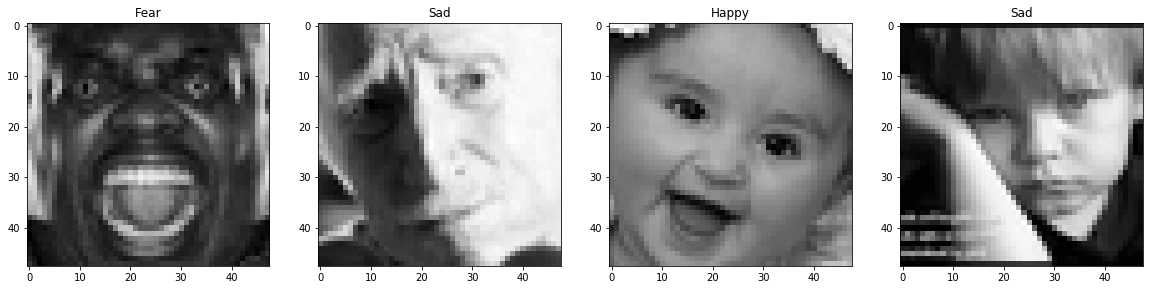

In [12]:
# Display the data
fig, ax = plt.subplots(1,4, figsize=(20, 5))
for i in range(4):
    img, emotion = train_dataset.__getitem__(i)
    ax[i].imshow(img.reshape(48, 48), cmap='gray')
    ax[i].set_title(LABELS[emotion])
plt.show()

## Train the network

In [18]:
import torch
from tqdm import tqdm
import numpy as np

use_cuda = torch.cuda.is_available()
print("Use cuda:", use_cuda)
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
device = torch.device("cuda" if use_cuda else "cpu")

model = n.EmotionClassifier().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=10e-6)
loss_function = torch.nn.NLLLoss()
loss_history = []
print(model.named_parameters)
#def l2_reg(weights, batch_size, penalty):
    

for epoch in range(20):
    print("Epoch", epoch+1)
    for imgs, emos in tqdm(train_loader):
        data = imgs.to(device)
        optimizer.zero_grad()
        fwd = model(data)
        loss = loss_function(fwd, emos.to(device).long())
        loss.backward()
        loss_history.append(loss.item())
        optimizer.step()
    print("Average Loss:", np.mean(loss_history))

plt.plot(np.arange(len(loss_history)), loss_history)
plt.show()

  0%|          | 0/180 [00:00<?, ?it/s]

Use cuda: True
<bound method Module.parameters of EmotionClassifier(
  (convolutions): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.25, inplace=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU()
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dropout(p=0.25, inplace=False)
    (16): Flatten()
  )
  (fc1): Linear(in_features=20736, out_features=1024, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=F

 41%|████      | 73/180 [00:19<00:26,  3.99it/s]

KeyboardInterrupt: 

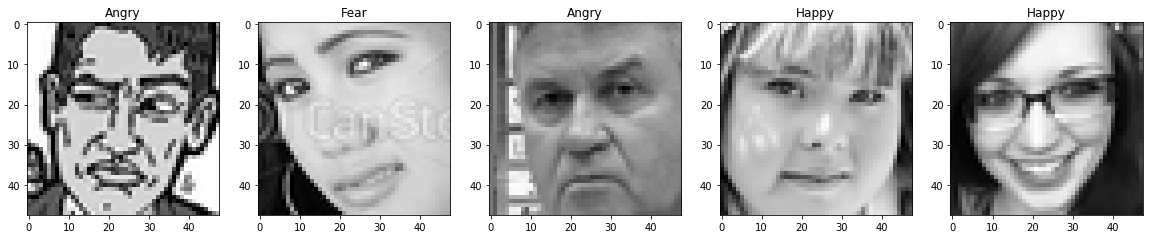

In [14]:
fig, ax = plt.subplots(1,5, figsize=(20, 4))
for imgs in test_loader:
    data = imgs.to(device)
    fwd = model(data)
    emotion = torch.argmax(fwd, dim=1)
    for i in range(imgs.shape[0]):
        img = data.cpu().numpy()[i]
        ax[i].imshow(img.reshape(48, 48), cmap='gray')
        ax[i].set_title(LABELS[emotion[i]])
    break
plt.show()

In [15]:
confusion_matrix = np.zeros((7,7))
corrects = 0
for imgs, emos in tqdm(val_loader):
    data = imgs.to(device)
    fwd = model(data)
    pred = torch.argmax(fwd, dim=1).cpu().numpy()
    emos = emos.cpu().numpy()
    corrects += np.sum(np.where(pred == emos, 1, 0))
    for i in range(7):
        confusion_matrix[pred[i]][emos[i]] += 1
accuracy = corrects * (100/len(validation_dataset))
print("Accuracy:", accuracy)

100%|██████████| 45/45 [00:03<00:00, 13.41it/s]

Accuracy: 53.56209719561053


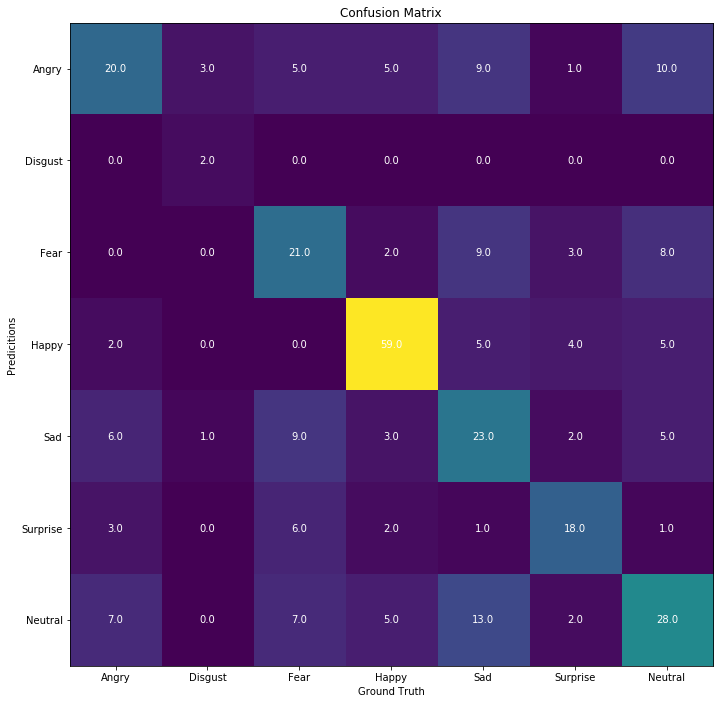

In [16]:
fig, ax = plt.subplots(figsize=(10,10))
img = ax.imshow(confusion_matrix)
for i in range(7):
    for j in range(7):
        text = ax.text(j, i, confusion_matrix[i, j],
                       ha="center", va="center", color="w")

ax.set_xticks(np.arange(7))
ax.set_yticks(np.arange(7))
ax.set_xticklabels(LABELS)
ax.set_yticklabels(LABELS)
ax.set_xlabel("Ground Truth")
ax.set_ylabel("Predicitions")
ax.set_title("Confusion Matrix")
fig.tight_layout()
plt.show()